In [1]:
import os
import subprocess

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import numpy as np
from pypcd import pypcd
from pycocotools.coco import COCO

In [2]:
# please see http://www.pointclouds.org/documentation/tutorials/compiling_pcl_posix.php for pcl installation
pcl_converter = '/usr/local/bin/pcl_converter'
pcl_mesh2pcd = '/usr/local/bin/pcl_mesh2pcd'

In [3]:
data_root = '../data/OilChangeDataset'
ann_file = '20171103_OilChange.json'
cat_ids = [1, 2, 4, 5, 6]
output_dir = 'objects'
target_size = 1000

In [4]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [5]:
coco = COCO(os.path.join(data_root, 'annotations', ann_file))

loading annotations into memory...
Done (t=1.58s)
creating index...
index created!


In [6]:
# create virtual display in background
subprocess.Popen(['X', ':99'])

In [7]:
# convert stl meshes to pcd point clouds
pcd_paths = []
for cat in coco.dataset['categories']:
    if cat['id'] in cat_ids:
        print(cat['name'])
        mesh_path = os.path.join(data_root, 'meshes', cat['mesh'])
        ply_path = os.path.join(output_dir, '{}.ply'.format(cat['name']))
        pcd_path = os.path.join(output_dir, '{}.pcd'.format(cat['name']))
        subprocess.call([pcl_converter, mesh_path, ply_path])
        subprocess.call([pcl_mesh2pcd, ply_path, pcd_path, '-leaf_size', '0.001', '-no_vis_result'], env={'DISPLAY': ':99'})
        pcd_paths.append(pcd_path)

oil_bottle
fluid_bottle
funnel
engine
blue_funnel


In [8]:
def visualize_pc(pc):
    fig = plt.figure()
    ax = p3.Axes3D(fig)
    ax.set_aspect('equal')

    ax.plot(pc[0], pc[1], pc[2], '.', ms=1)

    # properly scale axes
    center = 0.5 * (pc.max(axis=1) + pc.min(axis=1))
    max_range = np.max(pc.max(axis=1) - pc.min(axis=1))
    corners = np.reshape(np.mgrid[-1:2:2, -1:2:2, -1:2:2], (3, -1))
    corners = np.expand_dims(center, 1) + 0.5 * max_range * corners
    ax.plot(corners[0], corners[1], corners[2], alpha=0)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    plt.show()

/home/jimmywu/venvs/pin/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.15 because this will return a view instead of a copy -- see release notes for details.
  after removing the cwd from sys.path.


objects/oil_bottle.pcd (3, 144786)


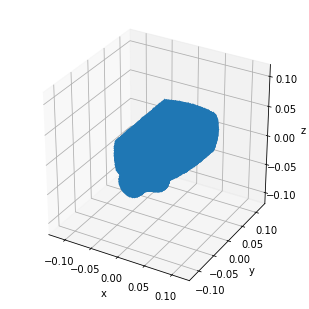

objects/fluid_bottle.pcd (3, 143322)


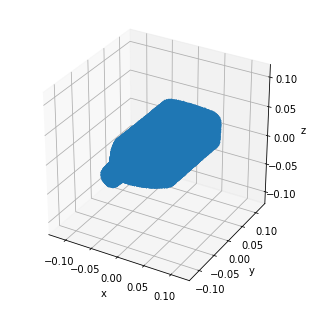

objects/funnel.pcd (3, 117979)


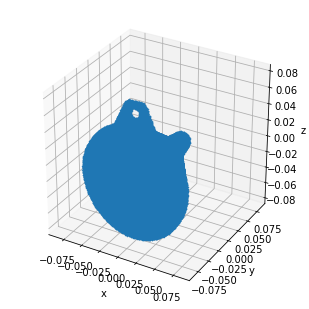

objects/engine.pcd (3, 301224)


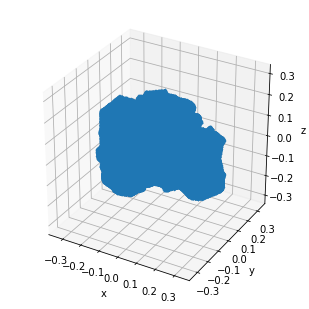

objects/blue_funnel.pcd (3, 173987)


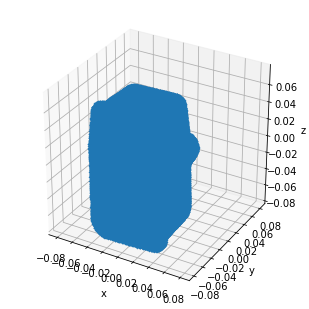

In [9]:
# visualize full point clouds
for pcd_path in pcd_paths:
    data = pypcd.PointCloud.from_path(pcd_path).pc_data[['x', 'y', 'z']]
    pc = data.view((np.float32, 3)).T
    print('{} {}'.format(pcd_path, pc.shape))
    visualize_pc(pc)

In [10]:
# downsample pcd point clouds
downsampled_pcd_paths = []
for cat in coco.dataset['categories']:
    if cat['id'] in cat_ids:
        pcd_path = os.path.join(output_dir, '{}.pcd'.format(cat['name']))
        data = pypcd.PointCloud.from_path(pcd_path).pc_data[['x', 'y', 'z']]
        downsample_factor = len(data) // target_size
        data = data[downsample_factor - 1::downsample_factor]
        np.random.seed(0)
        indices = np.random.permutation(len(data))[:target_size]
        indices.sort()
        data = data[indices]
        pc = pypcd.PointCloud.from_array(data)
        downsampled_pcd = '{}_{}.pcd'.format(cat['name'], target_size)
        downsampled_pcd_path = os.path.join(output_dir, downsampled_pcd)
        pc.save_pcd(downsampled_pcd_path, compression='ascii')
        downsampled_pcd_paths.append(downsampled_pcd_path)
        print(downsampled_pcd, pc.pc_data.shape[0])

oil_bottle_1000.pcd 1000
fluid_bottle_1000.pcd 1000
funnel_1000.pcd 1000
engine_1000.pcd 1000
blue_funnel_1000.pcd 1000


objects/oil_bottle_1000.pcd (3, 1000)


/home/jimmywu/venvs/pin/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.15 because this will return a view instead of a copy -- see release notes for details.
  after removing the cwd from sys.path.


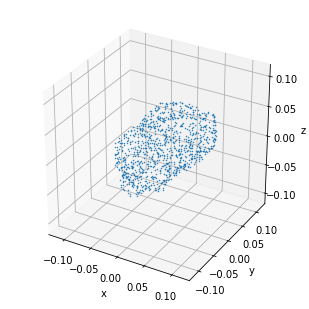

objects/fluid_bottle_1000.pcd (3, 1000)


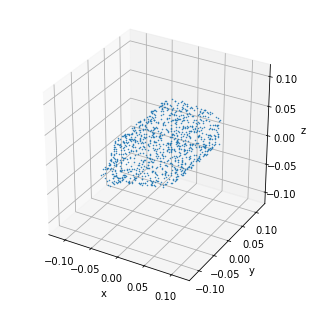

objects/funnel_1000.pcd (3, 1000)


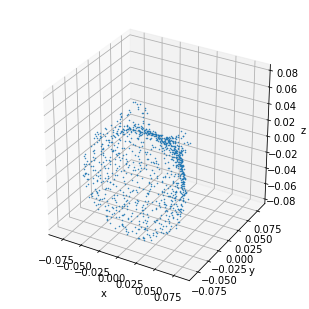

objects/engine_1000.pcd (3, 1000)


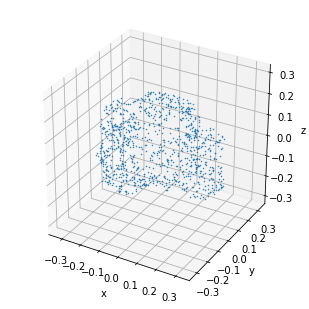

objects/blue_funnel_1000.pcd (3, 1000)


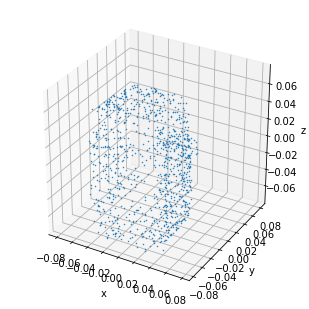

In [11]:
# visualize downsampled point clouds
for pcd_path in downsampled_pcd_paths:
    data = pypcd.PointCloud.from_path(pcd_path).pc_data[['x', 'y', 'z']]
    pc = data.view((np.float32, 3)).T
    print('{} {}'.format(pcd_path, pc.shape))
    visualize_pc(pc)